### MobileViT v2


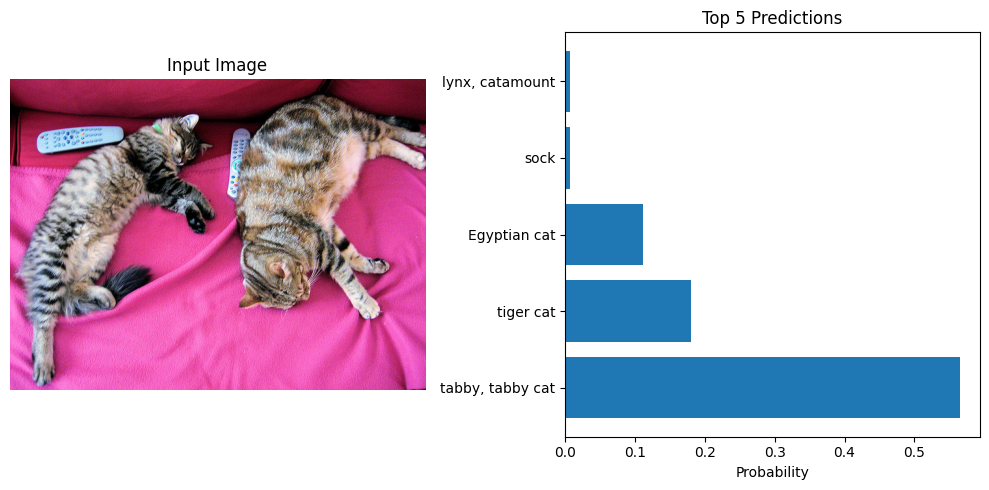

Top prediction: tabby, tabby cat (56.55% confidence)


In [4]:
from transformers import AutoImageProcessor, MobileViTV2ForImageClassification
from datasets import load_dataset
from PIL import Image
import requests
import torch 
import matplotlib.pyplot as plt
import numpy as np


url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Display the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Input Image")
plt.axis('off')


image_processor = AutoImageProcessor.from_pretrained(
    "apple/mobilevitv2-1.0-imagenet1k-256"
)
model = MobileViTV2ForImageClassification.from_pretrained(
    "apple/mobilevitv2-1.0-imagenet1k-256",
    use_safetensors=True,
)

inputs = image_processor(image, return_tensors="pt")

logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
# Get top 5 predictions
top_k = 5
probs = torch.nn.functional.softmax(logits, dim=-1)
top_probs, top_indices = torch.topk(probs, top_k)

# Convert to lists
top_probs = top_probs.squeeze().tolist()
top_indices = top_indices.squeeze().tolist()

# Get class names
class_names = [model.config.id2label[idx] for idx in top_indices]

# Display top predictions
plt.subplot(1, 2, 2)
y_pos = np.arange(len(class_names))
plt.barh(y_pos, top_probs, align='center')
plt.yticks(y_pos, class_names)
plt.xlabel('Probability')
plt.title('Top 5 Predictions')

plt.tight_layout()
plt.show()

# Print the top prediction
predicted_label = logits.argmax(-1).item()
print(f"Top prediction: {model.config.id2label[predicted_label]} ({top_probs[0]:.2%} confidence)")

Inference API by Hugging Face

In [ ]:
import json, io, os, requests
from PIL import Image
import matplotlib.pyplot as plt
from dotenv import load_dotenv

load_dotenv()
API_TOKEN = os.getenv("HF_API_TOKEN")
if not API_TOKEN:
    raise RuntimeError("Переменная HF_API_TOKEN не найдена в .env!")

url   = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

buf = io.BytesIO()
image.save(buf, format="JPEG")
buf.seek(0)                      

API_URL = "https://api-inference.huggingface.co/models/apple/mobilevitv2-1.0-imagenet1k-256"
headers = {
    "Authorization": f"Bearer {API_TOKEN}",
    "Content-Type": "application/octet-stream",
}

resp = requests.post(API_URL, headers=headers, data=buf.read(), timeout=30)
resp.raise_for_status()      
preds = resp.json()

print(json.dumps(preds, indent=2, ensure_ascii=False))

plt.imshow(image)
plt.axis("off")
plt.title("Input image\nTop-1: "
          f"{preds[0]['label']} ({preds[0]['score']*100:.1f} %)")
plt.show()

HTTPError: 404 Client Error: Not Found for url: https://api-inference.huggingface.co/models/apple/mobilevitv2-1.0-imagenet1k-256